## Introduction

I didn't like the options available in `DataInterpolations.jl`, so I came up with my own concept that mainly keeps the linear interpolation intact, but rounds of the corners between the linear sections. The main recipe is this, per corner:
- Add 2 points on either side close to the corner, on their respectilve linear sections
- Remove the corner point
- Connect the 2 new points with a spline curve


The advantage of the spline curve over a polynomial one is that the connection can be $C^1$ smooth (i.e. the smoothed curve and its derivative are continuous) without the possibility of introducing large oscillations with the use of degree 3 polynomials.

## Derivation

### Linear interpolation

Given is the set of points $(\mathbf{p}_i)_{i=1}^n$ in $\mathbb{R}^2$, where we write $t$ and $u$ for the respective coordinates. We assume that the $t_i$ are strictly increasing. Linear interpolation of these points is then simply given by

$$
    u|_{[t_{i-1}, t_i]}(t) = \frac{u_i-u_{i-1}}{t_i-t_{i-1}}(t-t_{i-1}).
$$

### Spline substitution

For the construction of the smoothing we consider the consecutive points

$$
    \mathbf{p}_{i-1}, \mathbf{p}_{i}, \mathbf{p}_{i+1}.
$$

Now we disregard $\mathbf{p}_i$, and introduce 2 new points

\begin{align*}
    \mathbf{p}_{i-\frac{\lambda}{2}} =&\; \mathbf{p}_i - \frac{\lambda}{2}\Delta\mathbf{p}_i \\
    \mathbf{p}_{i+\frac{\lambda}{2}} =&\; \mathbf{p}_i + \frac{\lambda}{2}\Delta\mathbf{p}_{i+1}
\end{align*}

where $\Delta\mathbf{p}_i = \mathbf{p}_i - \mathbf{p}_{i-1}$ and the role of the parameter $\lambda \in [0,1]$ will be explained later.

We want to connect $\mathbf{p}_{i-\frac{\lambda}{2}}$ and $\mathbf{p}_{i+\frac{\lambda}{2}}$ with a smooth parametric curve 
$$
    \mathbf{C}_i : [0,1] \rightarrow \mathbb{R}^2
$$

such that:

- The connection can be expressed as 

$$
    u_i : \left[t_{i - \frac{\lambda}{2}}, t_{i + \frac{\lambda}{2}}\right] \rightarrow \mathbb{R},
$$

 i.e. the $t$ component of the curve must be invertible.

- The connection is continuous, i.e.

$$
    \mathbf{C}_i(0) = \mathbf{p}_{i-\frac{\lambda}{2}}, \quad \mathbf{C}_i(1) = \mathbf{p}_{i+\frac{\lambda}{2}}.
$$

- The derivative of the connection is continuous, i.e.
$$
    \mathbf{C}'_i(0) \propto \Delta\mathbf{p}_i, \quad \mathbf{C}'_i(1) \propto \Delta\mathbf{p}_{i+1}.
$$

<span style="color:red;">To do: motivate the construction of Cn below.</span>

\begin{align*}
    \mathbf{C}_{i-\frac{\lambda}{2}}(s) = (1-s)\mathbf{p}_{i-\frac{\lambda}{2}} + s\mathbf{p}_i \\
    \mathbf{C}_{i+\frac{\lambda}{2}}(s) = (1-s)\mathbf{p}_i + s\mathbf{p}_{i+\frac{\lambda}{2}}
\end{align*}

\begin{align*}
    \mathbf{C}_i(s) &=& (1-s)\mathbf{C}_{i-\frac{\lambda}{2}}(s) + s\mathbf{C}_{i+\frac{\lambda}{2}}(s) \\
    &=&  (1-s)^2\mathbf{p}_{i-\frac{\lambda}{2}} + 2s(1-s)\mathbf{p}_i + s^2\mathbf{p}_{i+\frac{\lambda}{2}} \\
    &=& \frac{\lambda}{2}(\Delta \mathbf{p}_{i+1} - \Delta \mathbf{p}_i)s^2 + \lambda \Delta \mathbf{p}_i s + \mathbf{p}_{i-\frac{\lambda}{2}} 
\end{align*}

Note that the second formulation tells us that $C_i$ is a convex combination of $\mathbf{p}_{i-\frac{\lambda}{1}}, \mathbf{p}_i, \mathbf{p}_{i + \frac{\lambda}{2}}$ for all $s \in [0,1]$ and thus always is in the convex hull of these points.

### Writing spline as a function $u(t)$

To write the spline curve as a function $u(t)$, we first need to obtain $s$ from $t$:

$$
    T_i(s) = \frac{1}{2}\lambda(\Delta t_{i+1} - \Delta t_i)s^2 + \lambda\Delta t_i s + t_{i-\frac{\lambda}{2}} = t.
$$

This yields

$$  
    S_i(t) = \frac{
            -\lambda \Delta t_i + \sqrt{\lambda^2\Delta t_i^2 + 2\lambda (\Delta t_{i+1} - \Delta t_i)\left(t - t_{i-\frac{\lambda}{2}}\right)}
        }{
            \lambda (\Delta t_{i+1} - \Delta t_i)
        },
$$

or, in the degenerate case that $\Delta t_{i+1} - \Delta t_i = 0$ (i.e. the 3 points are equally spaced),

$$
    S_i(t) = \frac{1}{\lambda}\frac{t - t_{i - \frac{\lambda}{2}}}{\Delta t_i}.
$$

Note that $\Delta t_i \ne 0$ by the assumption that the $t_n$ are strictly increasing, and we later revisit the question of why in practice $\lambda = 0$ is not a problem.

We conclude:

$$
 u_i(t) = \frac{\lambda}{2}(\Delta u_{i+1} - \Delta u_i)S_i(t)^2 + \lambda \Delta u_i S_i(t) + u_{i - \frac{\lambda}{2}}.
$$

### Extrapolation

We define $\Delta \mathbf{p}_{1} = \Delta \mathbf{p}_{2}$ and $\Delta \mathbf{p}_{n+1} = \Delta \mathbf{p}_n$. This yields

$$
    u_1(t) = \frac{\Delta u_2 }{\Delta t_2}(t - t_1) + u_1, \quad t \in \left[t_1, t_{1 + \frac{\lambda}{2}}\right]
$$

and

$$
    u_n(t) = \frac{\Delta u_n}{\Delta t_n}(t - t_n) + u_n, \quad t \in \left[t_{n - \frac{\lambda}{2}}, t_n\right].
$$ 

This means that the interpolation is linear towards its boundaries and thus can be smoothly extended linearly.

### Evaluating the interpolation

Once it is determined that the input $t$ is in the interval $[t_{i-1}, t_i]$, the interpolation is evalued as follows:

\begin{align*}
    u|_{[t_{i-1}, t_i]}(t) = 
    \begin{cases}
        u_{i-1}(t) &\text{if }& t_{i-1} \leq t \leq t_{i - 1 + \frac{\lambda}{2}} \\
        u_{i-1} + \frac{\Delta u_i}{\Delta t_i}(t - t_{i-1}) &\text{if }& t_{i - 1 + \frac{\lambda}{2}} \leq t \leq t_{i - \frac{\lambda}{2}} \\
        u_i(t) &\text{if }& t_{i - \frac{\lambda}{2}} \leq t \leq t_i
    \end{cases}
\end{align*}

## Integration

We are interested in integrating the smoothed interpolation from the start to some $t > t_1$. To compute this efficiently we need to know the integral of the interpolation over the various intervals. More precisely:

- For the linear sections we obtain

$$
    \int_{t_{i-1+\frac{\lambda}{2}}}^{t_{i-\frac{\lambda}{2}}} 
         u_{i-1} + \frac{\Delta u_i}{\Delta t_i}(\tau - t_{i-1})
    \text{d}\tau
    =
    (1 - \lambda)\Delta t_i 
    \left[
        u_{i-1}
        +
        \frac{1}{2}(1 - \lambda) \Delta u_i
    \right].
$$

- For the spline sections we obtain

\begin{align*}
    \int_{t_{i-\frac{\lambda}{2}}}^{t_{i + \frac{\lambda}{2}}} u_i(\tau)\text{d}\tau
    &=&
    \int_0^1 T'_i(s)u_i(T_i(s))\text{d}s \\ 
    &=&
    \int_0^1
        \left[\lambda(\Delta t_{i+1} - \Delta t_i)s + \lambda\Delta t_i\right]
        \left[\frac{\lambda}{2}(\Delta u_{i+1} - \Delta u_i)s^2 + \lambda \Delta u_i s + u_{i - \frac{\lambda}{2}}\right]
    \text{d}s \\
    &=& \frac{\lambda^2}{24}
    \left[
        \Delta t_i \left(-3\Delta u_i + \Delta u_{i+1}\right) +
        \Delta t_{i+1} \left(-\Delta u_i + 3 \Delta u_{i+1}\right)
    \right]
    +
    \frac{\lambda}{2}(\Delta t_i + \Delta t_{i+1})u_i.
\end{align*}

We now define the new set of points $(\tilde{\mathbf{p}}_j)_{j=1}^{2n}$ given by all the $\mathbf{p}_{i - \frac{\lambda}{2}}, \mathbf{p}_{i+ \frac{\lambda}{2}}$ and the original boundary points, sorted by $t$. Then for $t \in \left[\tilde{t}_{J-1}, \tilde{t}_J\right]$ we have

\begin{align*}
    U(t) = \int_{t_1}^t u(\tau)\text{d}\tau = \sum_{j = 2}^{J-1} \int_{\tilde{t}_{j-1}}^{\tilde{t}_j} u(\tau)\text{d}\tau + \int_{\tilde{t}_{J-1}}^t u(\tau)\text{d}\tau,
\end{align*}

Where the summed integrals are given by the values above. For the last integral:

- If $J$ is odd then the last integral is of a linear section:

$$
    \int_{\tilde{t}_{J-1}}^t u(\tau)\text{d}\tau = \left((t-t_I) - \frac{\lambda}{2}\Delta t_{I+1}\right)u_I
     + 
     \frac{1}{2}\frac{\Delta u_{I+1}}{\Delta t_{I+1}}\left[(t-t_I)^2 - \frac{\lambda^2}{4}\Delta t_{I+1}^2\right]
$$

where $I = \frac{J-1}{2}$.

- If $J$ is even the last integral is of a spline section:

\begin{align*}
    \int_{\tilde{t}_{J-1}}^t u_\frac{J}{2}(\tau)\text{d}\tau &=& 
    \int_0^{S_\frac{J}{2}(t)} T'_\frac{J}{2}(s)u_\frac{J}{2}\left(T_\frac{J}{2}(s)\right)\text{d}s \\
    &=&
    \int_0^{S_I(t)}
        \left[\lambda(\Delta t_{I+1} - \Delta t_I)s + \lambda\Delta t_I\right]
        \left[\frac{\lambda}{2}(\Delta u_{I+1} - \Delta u_I)s^2 + \lambda \Delta u_I s + u_{I - \frac{\lambda}{2}}\right]
    \text{d}s
\end{align*}

where $I = \frac{J}{2}$.


<span style="color:red;">To do: Work out the above integral.</span>

## Inverting the integral

We are interested in inverting $U(t)$ as defined above. Note that $U(t)$ is invertible if $u(t)$ is positive for all $t > t_1$. If we define

$$
    U_J = \int_{t_1}^{\tilde{t}_J}u(\tau)\text{d}\tau = \sum_{j = 2}^{J} \int_{\tilde{t}_{j-1}}^{\tilde{t}_j} u(\tau)\text{d}\tau,
$$

then solving $U(t) = V$ for $t$ where $V \in [U_{J-1}, U_J]$ amounts to solving

$$
    \int_{\tilde{t}_{J-1}}^t u(\tau)\text{d}\tau = V - U_{J-1}.
$$

For linear sections this yields a quadratic equation in $t$ with solution

$$
    t = t_I + \left[-\frac{u_I}{\Delta u_{I+1}} + \text{sign}\left(\frac{u_{I+1}}{u_{I+1}}\right)\sqrt{\left(\frac{u_I}{\Delta u_{I+1}}\right)^2 +\lambda\left(\frac{u_I}{\Delta u_{I+1}} + \frac{\lambda}{4}\right) +2\frac{V - U_{J-1}}{\Delta t_{I+1}\Delta u_{I+1}}}\right]\Delta t_{I+1}.
$$

 For spline sections this leads to a quartic equation in $s$:

 \begin{align*}
    3(\Delta t_{I+1} - \Delta t_I)(\Delta u_{I+1} - \Delta u_I)s^4 + \\
    4\Delta t_I (\Delta u_{I+1} - \Delta u_I) s^3 + \\
    12(\Delta t_{I+1} - \Delta t_I)\left(\Delta u_I + \frac{u_{I - \frac{\lambda}{2}}}{\lambda}\right)s^2 + \\
    24 \Delta u_I \left(\Delta u_I + \frac{u_{I - \frac{\lambda}{2}}}{\lambda}\right) s + \\
    - \frac{24}{\lambda^2}(V - U_{J-1}) = 0
 \end{align*}
 
 
This quartic equation can be solved with the [quartic formula](https://en.wikipedia.org/wiki/Quartic_function#General_formula_for_roots).

[Quartic equation at Wolfram Alpha](https://www.wolframalpha.com/input?i=integrate+%28lambda*%28t_2+-+t_1%29*s+%2B+lambda*t_1%29*%28lambda%2F2+*+%28u_2+-+u_1%29*s%5E2+%2B+lambda*u_1+%2B+u_3%29+ds+from+0+to+S)

## Examples

In [1]:
using Pkg
Pkg.activate(".")
using SmoothInterpolation
using Plots
using Random

Random.seed!(2);

  Activating project at `c:\Users\konin_bt\Ribasim_development\SmoothInterpolation`


In [2]:
u = rand(10)
t = cumsum(rand(10))

itp = SmoothedLinearInterpolation(u, t; extrapolate = true)

SmoothedLinearInterpolation with 10 points
┌──────────┬──────────┐
│     time │        u │
├──────────┼──────────┤
│ 0.570199 │ 0.898901 │
│  1.09097 │ 0.722093 │
│  1.34126 │ 0.352522 │
│  1.50584 │ 0.230493 │
│    1.562 │ 0.359622 │
│  1.80602 │ 0.883354 │
│  2.18398 │ 0.549894 │
│  2.62664 │ 0.858798 │
│  3.44906 │ 0.520043 │
│  3.79432 │ 0.875899 │
└──────────┴──────────┘


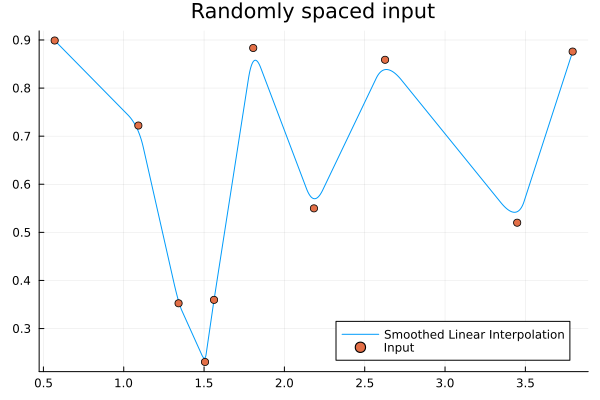

In [3]:
plot(itp, label = "Smoothed Linear Interpolation")
title!("Randomly spaced input")
scatter!(itp.t, itp.u, label = "Input")

In [4]:
# t = Float64[1, 2, 3, 5, 6, 7, 9, 10, 11, 13]
# itp = SmoothedLinearInterpolation(u,t)

# plot(itp, label = "Smoothed Linear Interpolation")
# title!("Some equispaced points")
# scatter!(itp.t, itp.u, label = "Input")

In [5]:
t_eval = range(t[1], t[end], 1000)
Δt = t_eval[2] - t_eval[1]
u_eval = itp.(t_eval)
V = 0.5 * (u_eval[1:end-1] + u_eval[2:end]) * Δt
V = cumsum(V)
pushfirst!(V, 0)
plot(V, t_eval, label = "Numerical integral inverse")
title!("Integral inverse")

itp_inv = SmoothedLinearInterpolationIntInv(itp)
scatter!(itp_inv.t, itp_inv.u, label = "Known points on integral inverse")
plot!(itp_inv, label = "Exact integral inverse")

AssertionError: AssertionError: 0 <= s <= 1